In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_1 = pd.read_csv('penguins.csv')
df_1 = df_1.drop('Comments', axis = 1)
df = df_1[['Species','Culmen Length (mm)','Culmen Depth (mm)','Flipper Length (mm)','Body Mass (g)']].copy()
df = df.dropna().reset_index(drop=True)
df.rename(columns={'Culmen Length (mm)':'culmenLength',
                    'Culmen Depth (mm)':'culmenDepth',
                    'Flipper Length (mm)':'flipperLength',
                    'Body Mass (g)':'bodyMass'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Species        342 non-null    object 
 1   culmenLength   342 non-null    float64
 2   culmenDepth    342 non-null    float64
 3   flipperLength  342 non-null    float64
 4   bodyMass       342 non-null    float64
dtypes: float64(4), object(1)
memory usage: 13.5+ KB


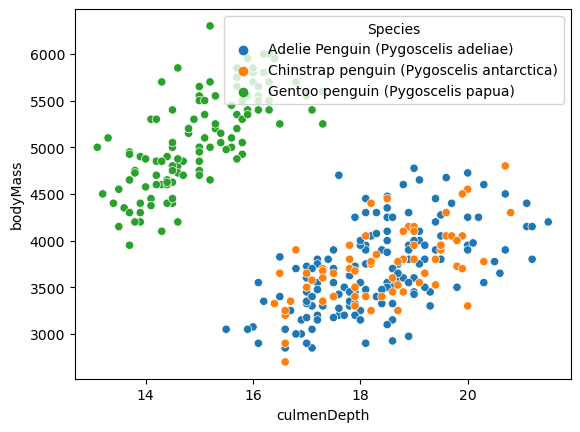

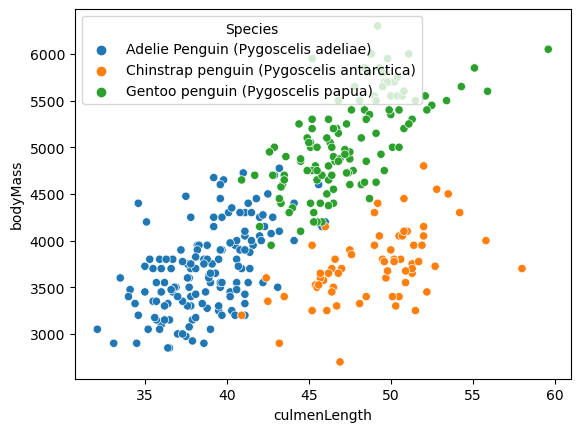

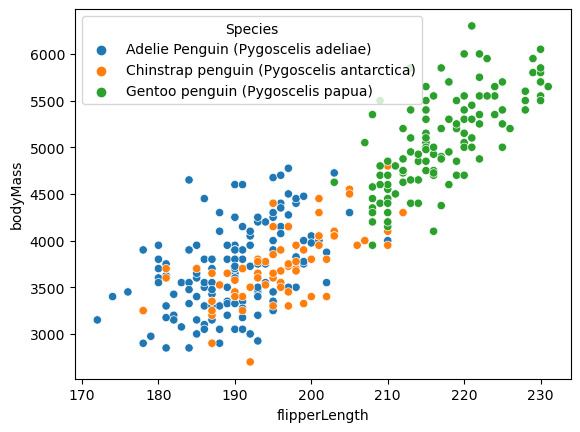

In [3]:
sns.scatterplot(data=df, x = 'culmenDepth', y = 'bodyMass', hue='Species')
plt.show()

sns.scatterplot(data=df, x = 'culmenLength', y = 'bodyMass', hue='Species')
plt.show()

sns.scatterplot(data=df, x = 'flipperLength', y = 'bodyMass', hue='Species')
plt.show()

In [4]:
def calcGiniImpurity(leftYes, leftNo, rightYes, rightNo):
    giLeft = 0
    giRight = 0
    weightLeft = 0
    weightRight = 0
    
    total = leftYes+leftNo+rightYes+rightNo
    
    if leftYes + leftNo != 0:
        giLeft = 1-((leftYes/(leftYes+leftNo))**2)-((leftNo/(leftYes+leftNo))**2)
        weightLeft = (leftYes+leftNo)/total
    if rightYes + rightNo != 0:
        giRight = 1-((rightYes/(rightYes+rightNo))**2)-((rightNo/(rightYes+rightNo))**2)
        weightRight = (rightYes+rightNo)/total
    
    giTotal = giLeft*weightLeft + giRight*weightRight
    return giTotal

In [5]:
def train(locDF, column, speciesToCheck):
    df = locDF.sort_values(column).reset_index(drop=True)
    
    thresholds = []
    giniImpurities = []

    for i in range(len(df)-1):
        threshold = round((df.loc[i, column] + df.loc[i+1, column])/2,2)
        thresholds.append(threshold)
    
    for i in range(len(thresholds)):
        underThresh = []
        overThresh = []
    
        for j in range(len(df)):
            if df.loc[j, column] < thresholds[i]:
                underThresh.append(df.loc[j, 'Species'])
            elif df.loc[j, column] > thresholds[i]:
                overThresh.append(df.loc[j, 'Species'])
            
        leftYes = 0
        leftNo = 0
        rightYes = 0
        rightNo = 0
        for j in range(len(underThresh)):
            if underThresh[j] == speciesToCheck:
                leftYes+=1
            else:
                leftNo+=1
        for j in range(len(overThresh)):
            if overThresh[j] == speciesToCheck:
                rightYes+=1
            else:
                rightNo+=1
        gi = calcGiniImpurity(leftYes,leftNo,rightYes,rightNo)
        giniImpurities.append([thresholds[i], gi])
    
    giDF = pd.DataFrame(giniImpurities, columns=['threshold','giniImpurity'])
    giDF.loc[giDF['giniImpurity'].idxmin()]
    
    return giDF.loc[giDF['giniImpurity'].idxmin()]

In [6]:
species = df['Species'].unique()
species

array(['Adelie Penguin (Pygoscelis adeliae)',
       'Chinstrap penguin (Pygoscelis antarctica)',
       'Gentoo penguin (Pygoscelis papua)'], dtype=object)

In [7]:
train(df, 'flipperLength', species[2])

threshold       207.000000
giniImpurity      0.039481
Name: 213, dtype: float64

In [12]:
train(df.drop(df[df["flipperLength"] > species[2]].index), 'culmenLength', species[1])

threshold       44.650000
giniImpurity     0.078792
Name: 153, dtype: float64

In [9]:
def classificationTree(penguin):
    if penguin.loc[0,'Flipper Length (mm)'] > 207:
        return species[2]
    if penguin.loc[0,'Culmen Length (mm)'] > 44.65:
        return species[1]
    return species[0]

In [10]:
testPenguin = pd.read_csv('testPenguin.csv')
testPenguin.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,200,?,Anvers,Biscoe,"Adult, 1 Egg Stage",N1A13,Yes,11/29/07,46.6,14.6,222,5351,MALE,8.4362,-24.99169,NaN


In [11]:
x = classificationTree(testPenguin)
x

'Gentoo penguin (Pygoscelis papua)'